<center><h1>Payapulli_Joshua_HW5</h1></center>
<br>
<br>

Name: Joshua Payapulli
<br>
Github Username: Payapulli
<br>
USC ID: 3751786221

I am using 2 late days for this lab!

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import _tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.impute import SimpleImputer
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import xgboost as xgb

### (a) Obtain Data

Get the Accute Inamations Data Set

In [2]:
column_names = ['Temperature of patient','Occurrence of nausea','Lumbar pain',
               'Urine pushing (continuous need for urination)','Micturition pains',
               'Burning of urethra, itch, swelling of urethra outlet',
               'Inflammation of urinary bladder','Nephritis of renal pelvis origin']

df = pd.read_csv('../Data/diagnosis.data', header = None, names = column_names, sep = '\t',encoding = 'utf-16')

# Changing commas into decimal points
df['Temperature of patient'] = df['Temperature of patient'].str.replace(',', '.').astype(float)

# Changing yes and no into a binary value
df.replace({'yes': 1, 'no': 0}, inplace=True)
df

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",Inflammation of urinary bladder,Nephritis of renal pelvis origin
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


### (b) Build a decision tree

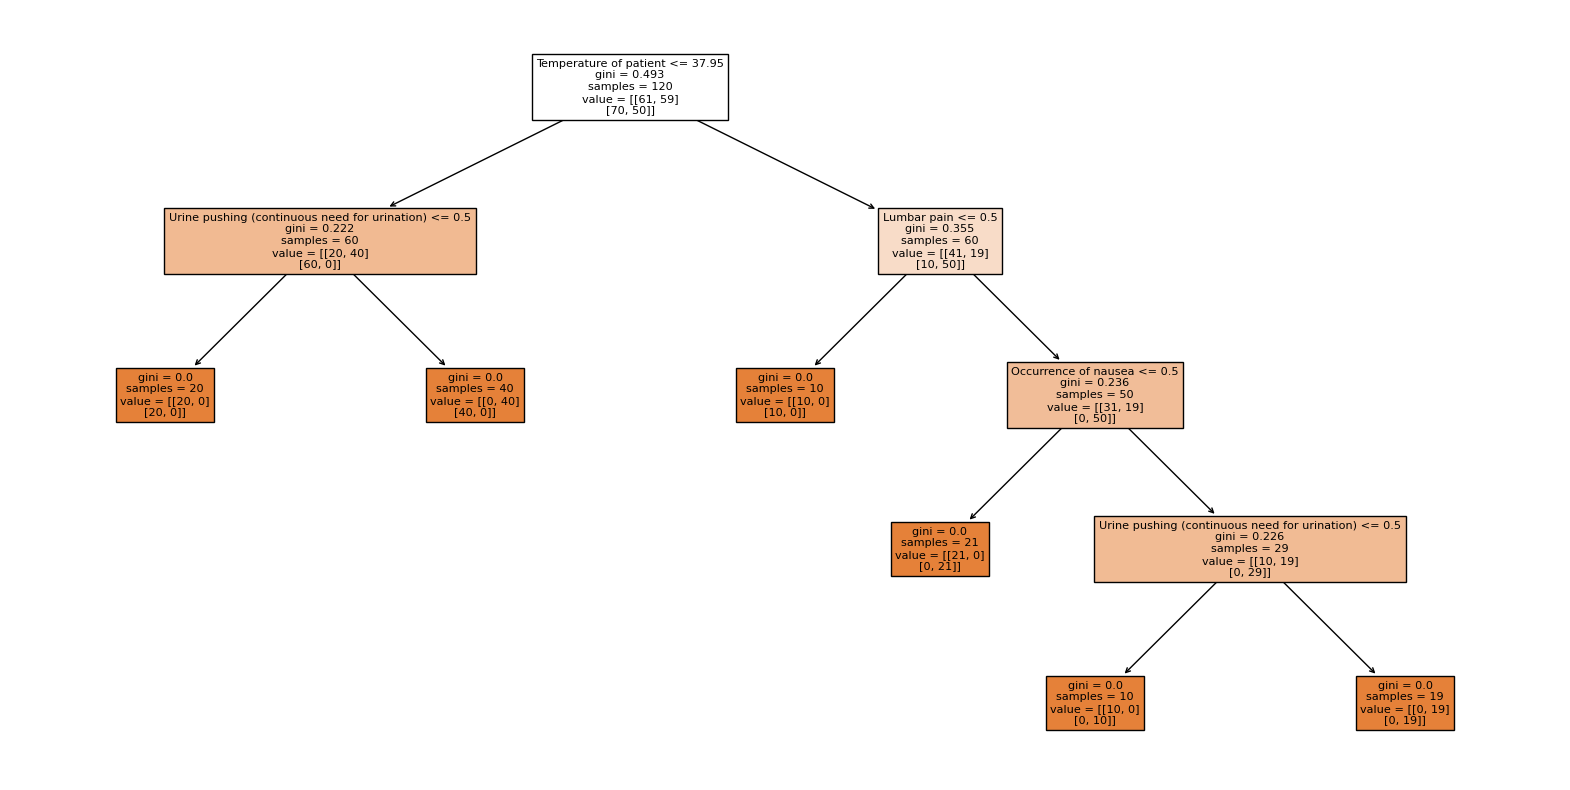

In [3]:
# Splitting features and response
X, y = df.iloc[:, :-2], df.iloc[:, -2:]

# Building the decision tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X, y)

feature_names = list(X.columns)

# Plot tree
plt.figure(figsize=(20,10))
plot_tree(decision_tree, feature_names=list(X.columns), filled=True, label='all')
plt.show()

### (c) Convert the decision rules

In [4]:
# Print out IF-THEN rules
def tree_to_output(tree, feature_names):
    tree_ = tree.tree_
    # convert the features in the order of the decision tree
    # into their respective names/labels
    features = [feature_names[i] for i in tree_.feature]

    def recurse(node, depth=0):
        # add an indendation as is done in python
        indent = "  " * depth
        # internal node
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            
            name, threshold = features[node], tree_.threshold[node]
            
            # left child
            print(indent + "IF ( {} <= {} )".format(name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            
            # right child
            print(indent + "ELSE")
            recurse(tree_.children_right[node], depth + 1)
        # leaf node
        else:
            values = tree_.value[node].squeeze()
            print(indent + "THEN return {}".format(values))
    
    # start at depth 0
    recurse(0)

tree_to_output(decision_tree, feature_names)

IF ( Temperature of patient <= 37.95000076293945 )
  IF ( Urine pushing (continuous need for urination) <= 0.5 )
    THEN return [[20.  0.]
 [20.  0.]]
  ELSE
    THEN return [[ 0. 40.]
 [40.  0.]]
ELSE
  IF ( Lumbar pain <= 0.5 )
    THEN return [[10.  0.]
 [10.  0.]]
  ELSE
    IF ( Occurrence of nausea <= 0.5 )
      THEN return [[21.  0.]
 [ 0. 21.]]
    ELSE
      IF ( Urine pushing (continuous need for urination) <= 0.5 )
        THEN return [[10.  0.]
 [ 0. 10.]]
      ELSE
        THEN return [[ 0. 19.]
 [ 0. 19.]]


### (d) Cost-Complexity Pruning with CV

In [5]:
# split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the initial tree with full path
clf_initial = DecisionTreeClassifier(random_state=42)
clf_initial.fit(X_train, y_train)
path = clf_initial.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Setup GridSearchCV
param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the training and validation accuracy scores
train_scores = grid_search.cv_results_['mean_train_score']
validation_scores = grid_search.cv_results_['mean_test_score']

# Create a DataFrame to display the results
table = pd.DataFrame({
    'Alpha': ccp_alphas,
    'Training Score': train_scores,
    'Validation Score': validation_scores
})
table

,Alpha,Training Score,Validation Score
0,0.000000,1.000000,1.000000
1,0.050813,0.893506,0.842105
2,0.080347,0.807348,0.770000
3,0.109929,0.658612,0.614211
4,0.202673,0.465619,0.387368


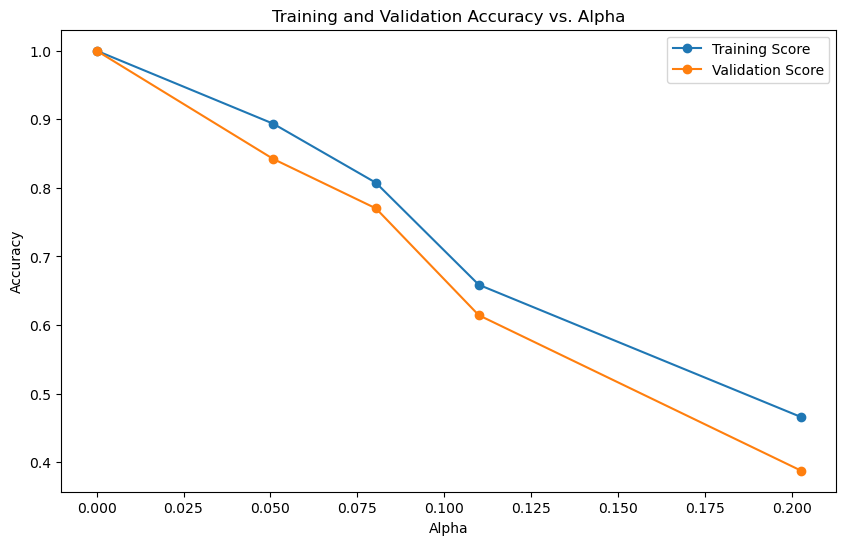

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Training Score')
plt.plot(ccp_alphas, validation_scores, marker='o', label='Validation Score')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Alpha')
plt.legend()
plt.show()

Given we are aiming for a minimal decision tree with high interpretability, I am selecting alpha = 0.08034677285548367 as the best alpha. We can see that this alpha gives us a validation score of 0.770 which is significantly lower than the alphas above in the table but we choose this in the interest of high interpretability and greater pruning of the tree.

best alpha: 0.08034677285548367


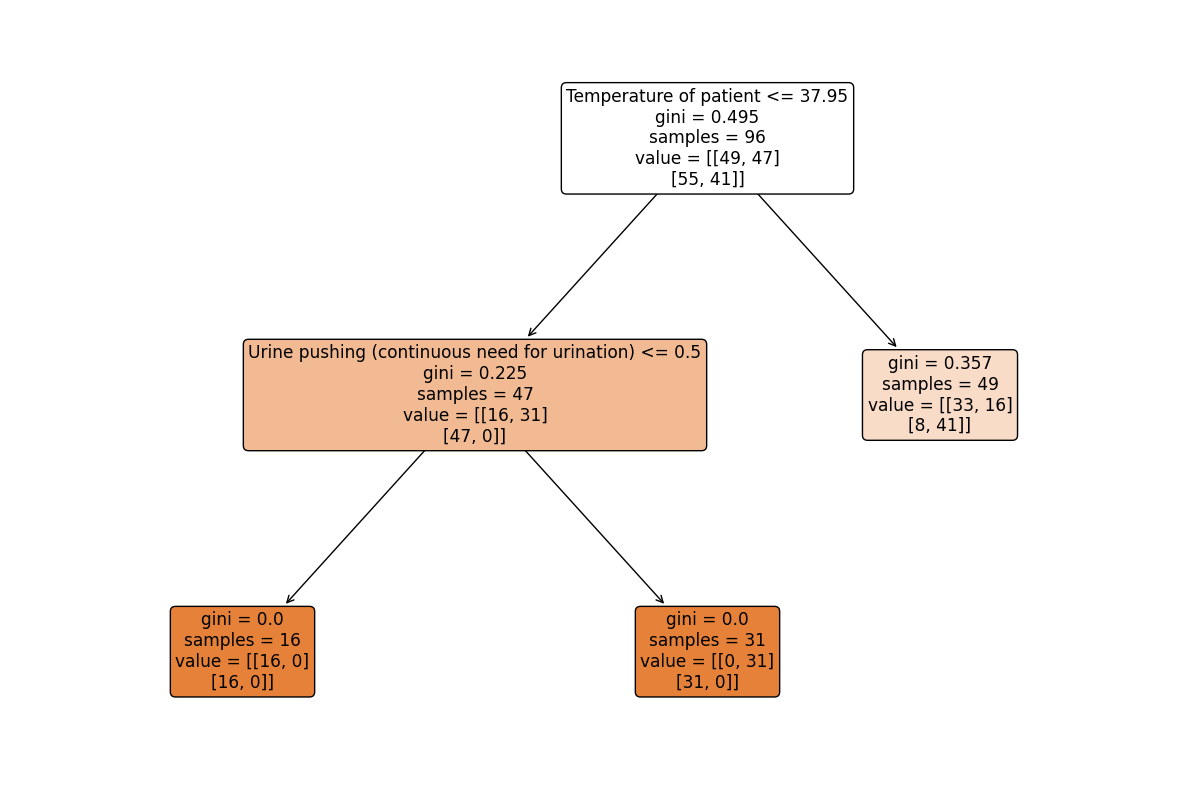

In [7]:
# selecting alpha = 0.08034677285548367
best_alpha_index = 2

best_alpha = ccp_alphas[best_alpha_index]
print(f'best alpha: {best_alpha}')

# train model on best alpha we have found above
best_model = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
best_model.fit(X_train, y_train)

plt.figure(figsize=(15, 10))
plot_tree(best_model, filled=True, feature_names=list(X_train.columns), rounded=True)
plt.show()

In [8]:
# printing out the decision rules
feature_names = list(X_train.columns)
tree_to_output(best_model, feature_names)

IF ( Temperature of patient <= 37.95000076293945 )
  IF ( Urine pushing (continuous need for urination) <= 0.5 )
    THEN return [[16.  0.]
 [16.  0.]]
  ELSE
    THEN return [[ 0. 31.]
 [31.  0.]]
ELSE
  THEN return [[33. 16.]
 [ 8. 41.]]


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [9]:
headers = []
with open("../data/communities.names", "r") as file:
    for line in file:
        if "@attribute" in line:
            line = line.split(" ")
            headers.append(line[1])

# skipping over values
cc_df = pd.read_csv("../data/communities.data", header=None, na_values='?')
cc_df.columns = headers
cc_df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [10]:
# train and test split
tr_cc_df, te_cc_df = cc_df.iloc[:1495, :], cc_df.iloc[1495:,:]
print("Training set")
tr_cc_df

Training set


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,6,NaN,NaN,Hillsboroughtown,8,0.00,0.59,0.01,0.69,1.00,...,0.02,0.14,0.22,NaN,NaN,NaN,NaN,0.00,NaN,0.03
1491,6,NaN,NaN,Orangecity,8,0.16,0.62,0.03,0.74,0.48,...,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19,0.20
1492,13,NaN,NaN,Waycrosscity,8,0.01,0.36,0.95,0.24,0.03,...,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.00,NaN,0.30
1493,39,85.0,49056.0,Mentorcity,8,0.06,0.53,0.01,0.98,0.05,...,0.08,0.15,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [11]:
print("Testing set")
te_cc_df

Testing set


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,6,NaN,NaN,MillValleycity,8,0.00,0.20,0.03,0.91,0.23,...,0.01,0.23,0.73,NaN,NaN,NaN,NaN,0.00,NaN,0.12
1496,48,NaN,NaN,LiveOakcity,8,0.00,0.55,0.13,0.78,0.15,...,0.01,0.18,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.11
1497,35,NaN,NaN,Portalescity,8,0.00,0.52,0.04,0.59,0.05,...,0.01,0.18,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.12
1498,42,17.0,25112.0,Fallstownship,8,0.04,0.51,0.07,0.92,0.09,...,0.06,0.13,0.16,NaN,NaN,NaN,NaN,0.00,NaN,0.06
1499,51,683.0,48952.0,Manassascity,8,0.03,0.59,0.20,0.75,0.19,...,0.03,0.23,0.06,NaN,NaN,NaN,NaN,0.00,NaN,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


### (b) Missing values

In [12]:
# removing nonpredictive features
cc_df_pred = cc_df.iloc[:, 5:]
tr_cc_df_pred = tr_cc_df.iloc[:, 5:]
te_cc_df_pred = te_cc_df.iloc[:, 5:]

# training the imputer on the training data and using this to impute on test data also
imputer = SimpleImputer(strategy="mean")
imputer.fit(tr_cc_df_pred)
tr_cc_df_imputed = pd.DataFrame(imputer.transform(tr_cc_df_pred), columns=tr_cc_df_pred.columns)
te_cc_df_imputed = pd.DataFrame(imputer.transform(te_cc_df_pred), columns=te_cc_df_pred.columns)


# check if we have successfully applied imputation for all missing values
if tr_cc_df_imputed.isnull().sum().sum() == 0:
    print("All missing data has been imputed")
else:
    print("There is still missing data")

tr_cc_df_imputed

All missing data has been imputed


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.500000,0.61,0.190000,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03


In [13]:
te_cc_df_imputed

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.11
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.06
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.03,0.23,0.06,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.09
495,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.45
496,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
497,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


### (c) Plot a correlation matrix

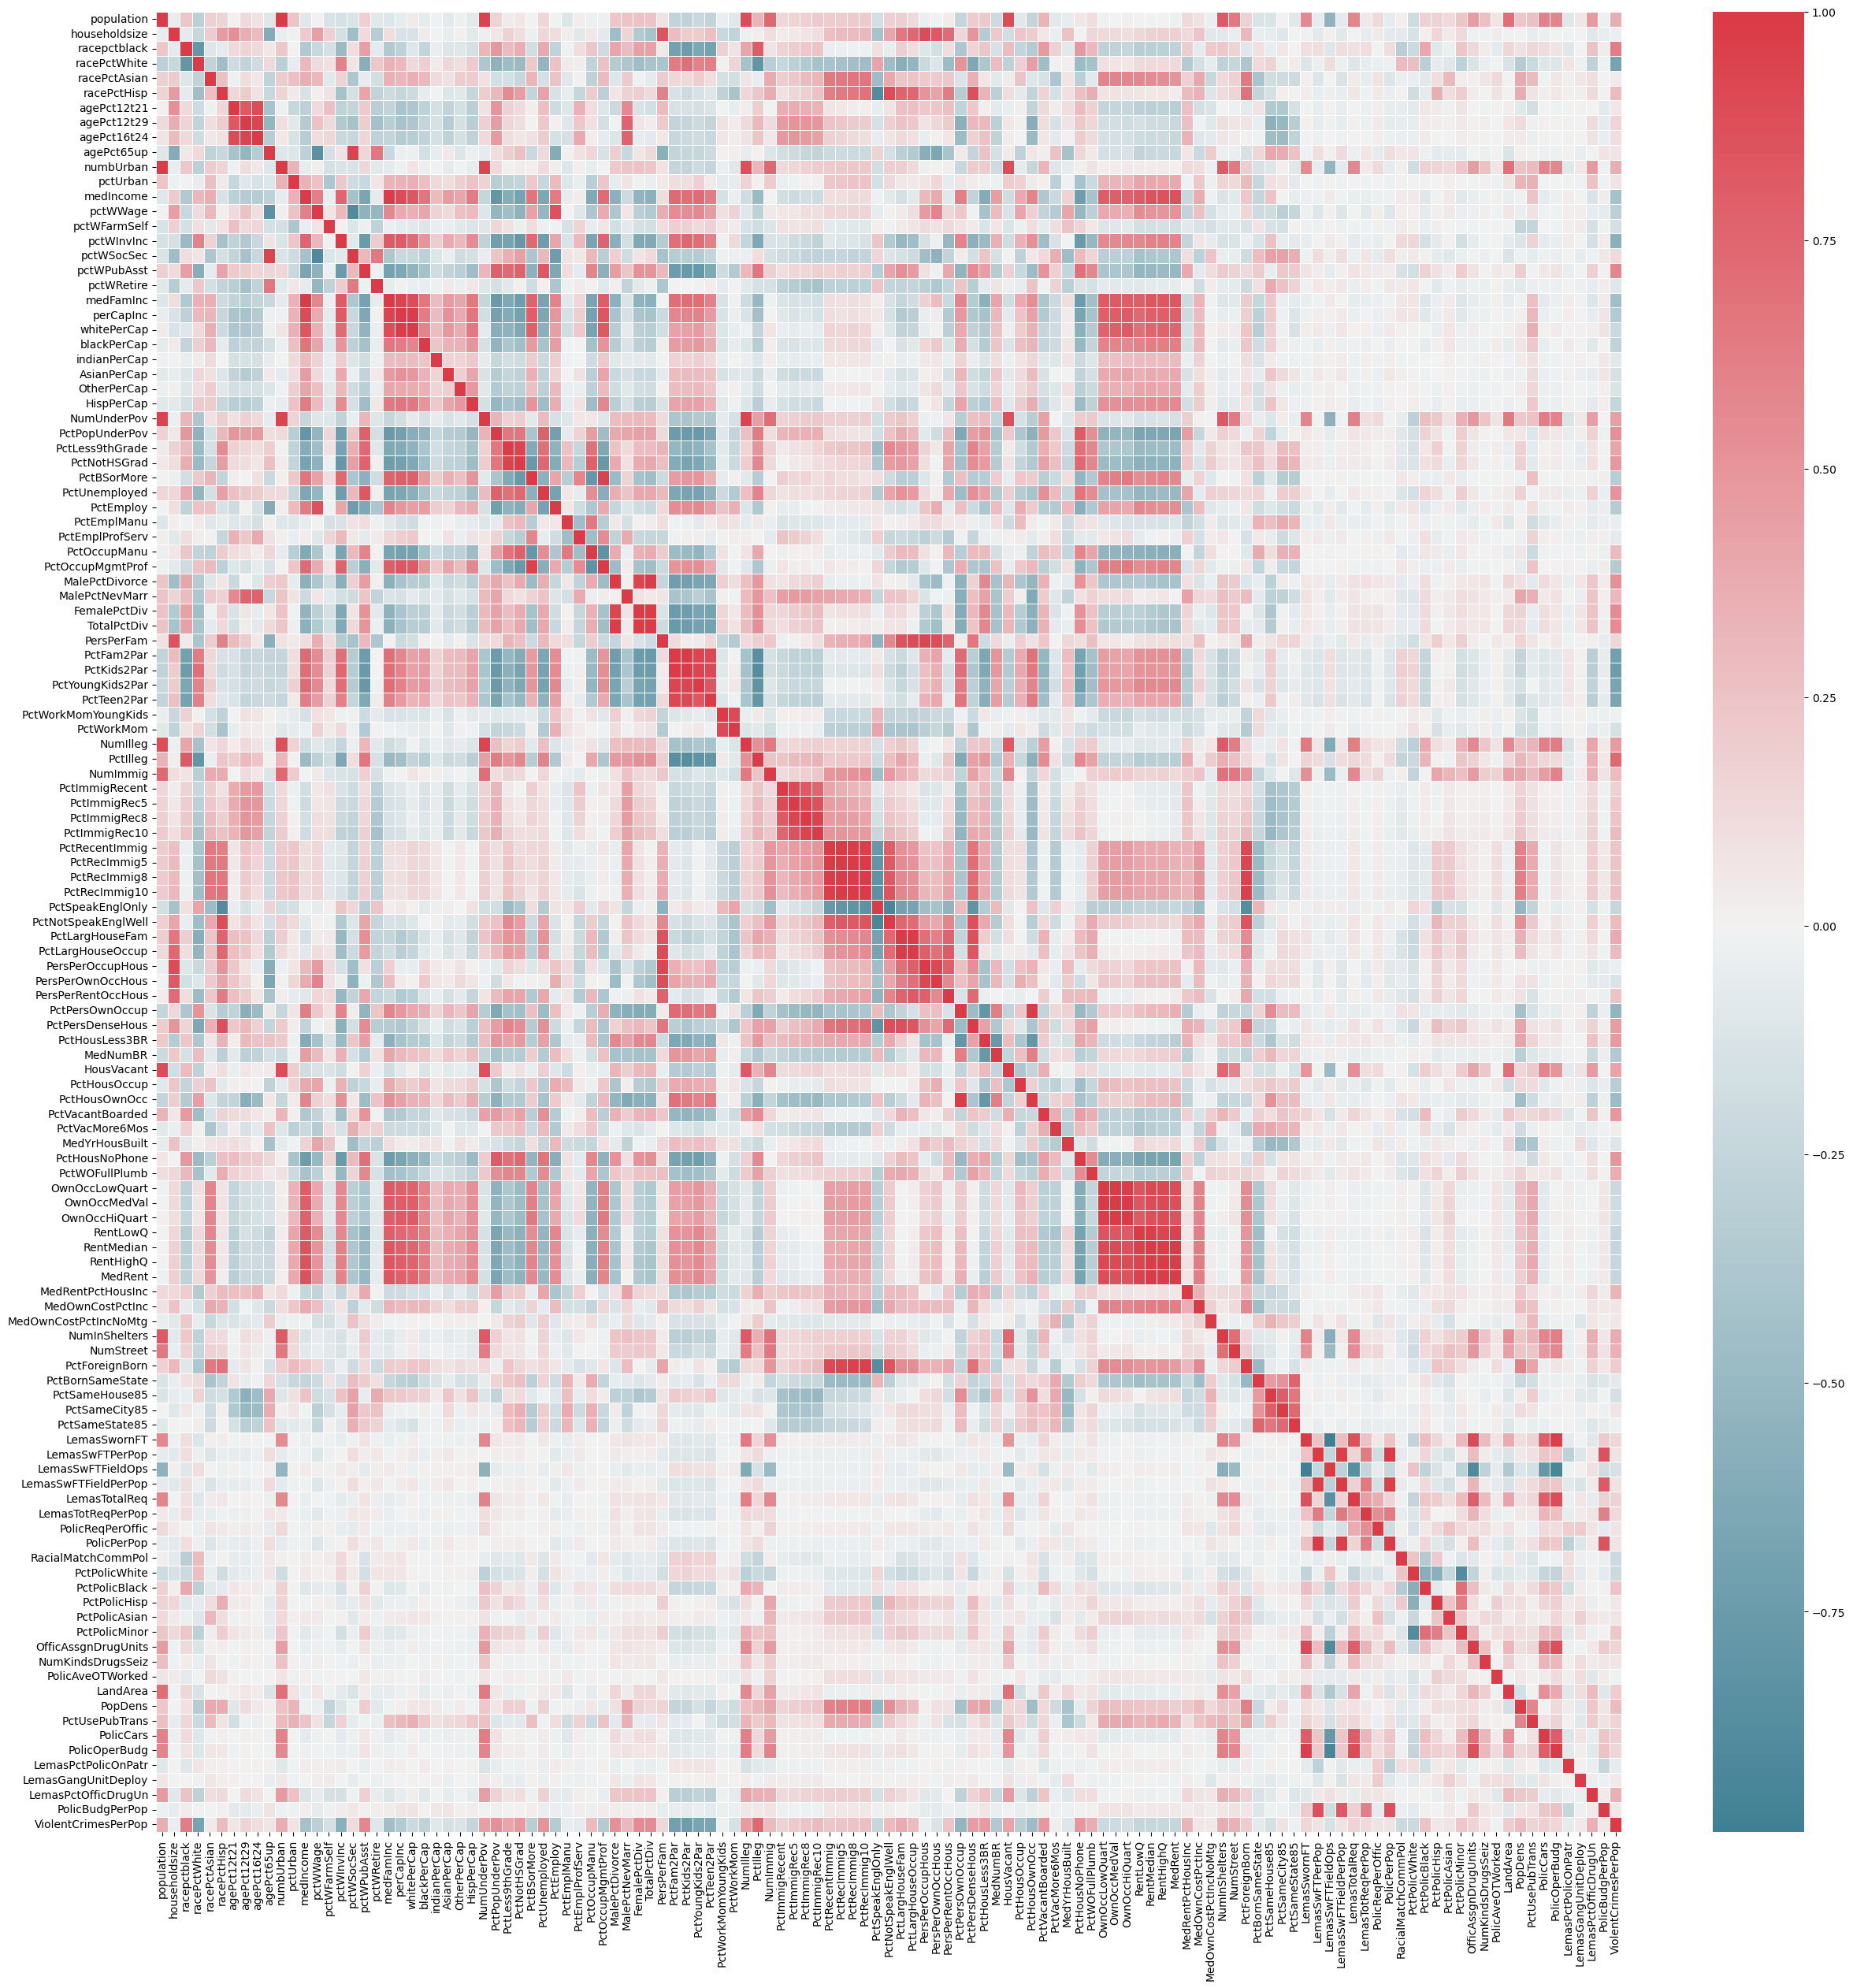

In [14]:
cc_df_imputed = pd.concat([tr_cc_df_imputed, te_cc_df_imputed])

fig, axes = plt.subplots(figsize=(30, 30))
# color coding red for positive correlation and blue for negative
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cc_df_imputed.corr(), ax=axes, cmap=cmap, center=0, linewidths=.5)
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [15]:
# Extract standard deviation and mean for each column using describe()
cv_df = cc_df_imputed.describe()

# Calculate Coefficient of Variation (CV) for each column
cv_df.loc['CV'] = cv_df.loc['std'] / cv_df.loc['mean']

# Extract rows corresponding to standard deviation, mean, and CV
cv_df = cv_df.loc[['CV']]

cv_df.T

,CV
population,2.203503
householdsize,0.353298
racepctblack,1.410920
racePctWhite,0.323782
racePctAsian,1.359162
...,...
LemasPctPolicOnPatr,0.120471
LemasGangUnitDeploy,0.360299
LemasPctOfficDrugUn,2.555266
PolicBudgPerPop,0.343782


### (e) Scatter plots and box plots for highest CV features

In [16]:
# select features with highest CV
num_features = int(np.sqrt(128))
top_features = cv_df.T.nlargest(num_features, 'CV').index
top_features

Index(['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig',
       'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban',
       'HousVacant', 'LandArea', 'racePctHisp'],
      dtype='object')

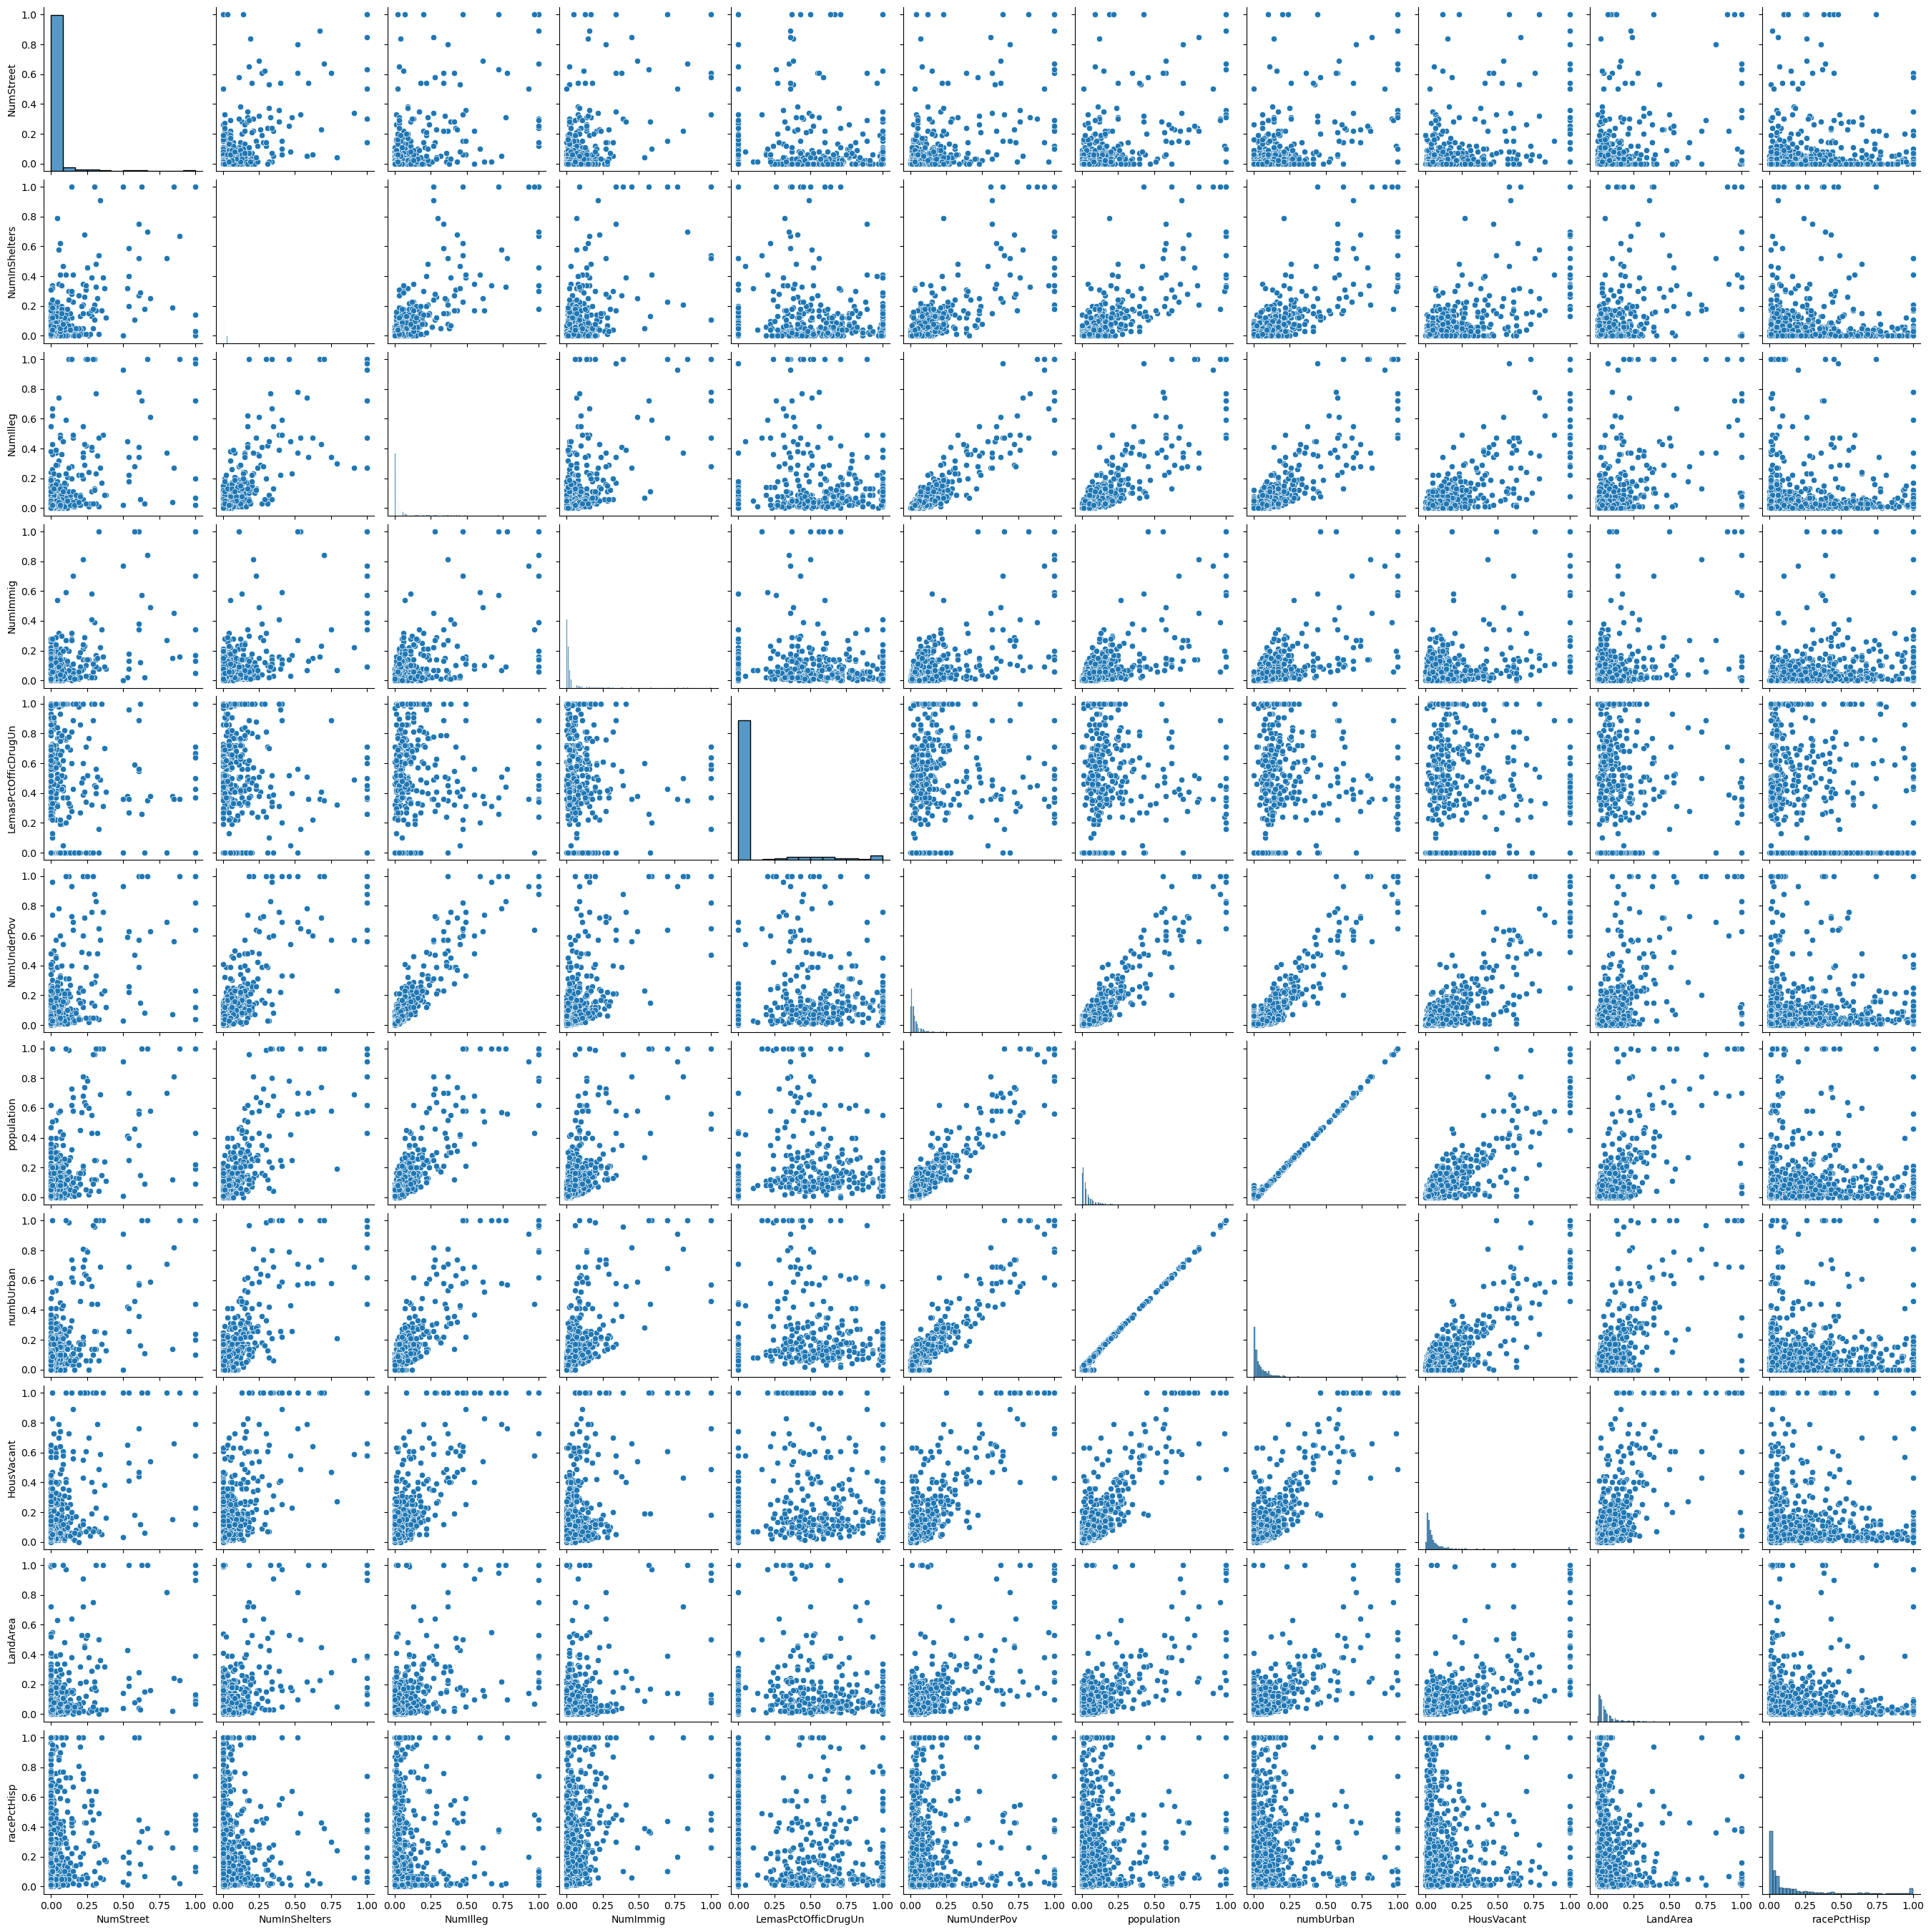

In [17]:
# scatter plots
sns.pairplot(cc_df_imputed[top_features])
plt.show()

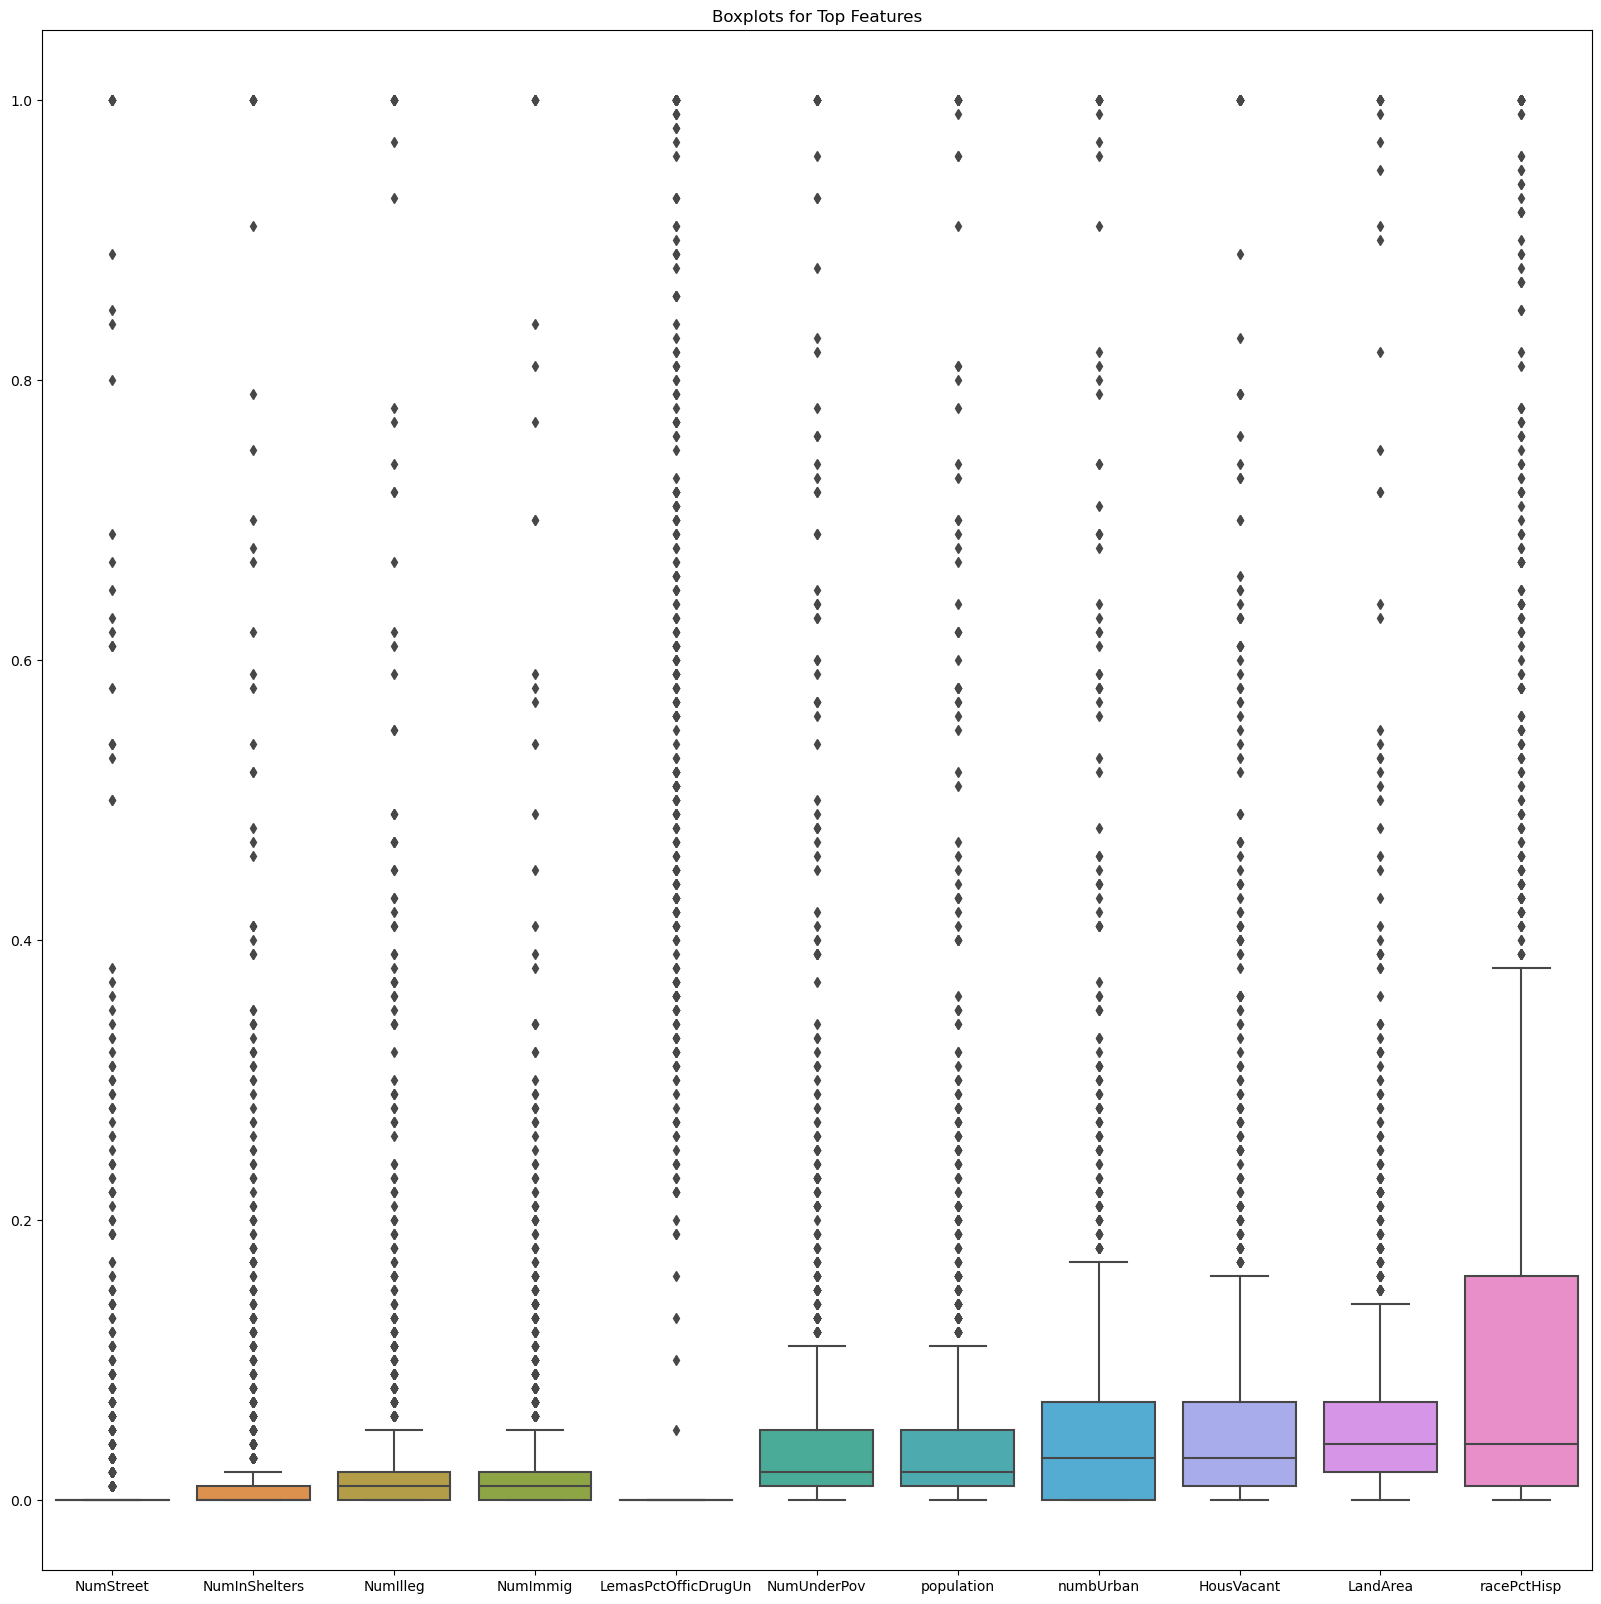

In [18]:
# box plots
fig, axes = plt.subplots(figsize=(20, 20))
sns.boxplot(data=cc_df_imputed[top_features], ax=axes)
plt.title("Boxplots for Top Features")
plt.show()

We cannot draw any definitive conclusions about the significance of the features just from the scatter plots. However, we can see that some pairs of features such as population vs NumUnderPov have a fairly linear correlation which may indicate that these features will be significant in predicting the response. Also, some plots show there being clusters of data such as with NumbUrban vs HousVacant which also may indicate their being an interesting relationship between these two features.

Once again though, although we can gain insight into the relationship between these features from the scatter plots, we cannot draw definitive conclusions about their statistical significance.

### (f) Fit a linear model

In [19]:
X_train, y_train = tr_cc_df_imputed.iloc[:, :-1], tr_cc_df_imputed.iloc[:, -1]
X_test, y_test = te_cc_df_imputed.iloc[:, :-1], te_cc_df_imputed.iloc[:, -1]

# Train linear model and print summary
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()
display(model.summary())

# prediction
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)

# Calculate and print the MSE
linear_mse = mean_squared_error(y_test, y_pred)
print(f"\nLinear Model Test Mean Squared Error: {linear_mse}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.711
Model:                             OLS   Adj. R-squared:                  0.686
Method:                  Least Squares   F-statistic:                     27.94
Date:                 Sun, 29 Oct 2023   Prob (F-statistic):          6.56e-291
Time:                         23:50:02   Log-Likelihood:                 955.40
No. Observations:                 1495   AIC:                            -1667.
Df Residuals:                     1373   BIC:                            -1019.
Df Model:                          121                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.4544      0.904      0.503      0.615      -1.319       2.228
population               -0.0199      0.477     -0.042      0.967      -0.955       0.916
householdsize            -0.0157      0.098     -0.161      0.872      -0.207       0.176
racepctblack              0.2848      0.060      4.754      0.000       0.167       0.402
racePctWhite              0.0106      0.067      0.159      0.874      -0.120       0.141
racePctAsian             -0.0278      0.041     -0.670      0.503      -0.109       0.054
racePctHisp               0.0180      0.065      0.275      0.784      -0.110       0.146
agePct12t21               0.1792      0.129      1.387      0.166      -0.074       0.433
agePct12t29              -0.3451      0.186     -1.858      0.063      -0.709       0.019
agePct16t24              -0.1237      0.198     -0.626      0.531      -0.511       0.264
agePct65up                0.0597      0.124      0.481      0.630      -0.184       0.303
numbUrban                -0.1260      0.465     -0.271      0.786      -1.038       0.786
pctUrban                  0.0484      0.019      2.581      0.010       0.012       0.085
medIncome                -0.1784      0.202     -0.881      0.378      -0.575       0.219
pctWWage                 -0.1399      0.107     -1.309      0.191      -0.350       0.070
pctWFarmSelf              0.0460      0.023      1.960      0.050   -3.35e-05       0.092
pctWInvInc               -0.2031      0.081     -2.505      0.012      -0.362      -0.044
pctWSocSec                0.1368      0.125      1.092      0.275      -0.109       0.383
pctWPubAsst               0.0601      0.054      1.109      0.268      -0.046       0.166
pctWRetire               -0.1249      0.045     -2.802      0.005      -0.212      -0.037
medFamInc                 0.3049      0.189      1.617      0.106      -0.065       0.675
perCapInc                -0.0485      0.222     -0.219      0.827      -0.484       0.387
whitePerCap              -0.1923      0.179     -1.072      0.284      -0.544       0.160
blackPerCap              -0.0401      0.030     -1.358      0.175      -0.098       0.018
indianPerCap             -0.0436      0.023     -1.911      0.056      -0.088       0.001
AsianPerCap               0.0301      0.022      1.381      0.168      -0.013       0.073
OtherPerCap               0.0304      0.022      1.364      0.173      -0.013       0.074
HispPerCap                0.0330      0.029      1.150      0.250      -0.023       0.089
NumUnderPov               0.0737      0.192      0.383      0.702      -0.303       0.451
PctPopUnderPov           -0.2035      0.074     -2.736      0.006      -0.349      -0.058
PctLess9thGrade          -0.0584      0.079     -0.743      0.457      -0.213       0.096
PctNotHSGrad


Linear Model Test Mean Squared Error: 0.018141971135530077


### (g) Fit a ridge regression model

In [20]:
alphas = [10**e for e in range(-4, 4)]

# fit ridge regression model
ridge_model = RidgeCV(alphas=alphas, cv=KFold(n_splits=5))
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print("Best Alpha :", ridge_model.alpha_)
print(f"Ridge regression Test MSE: {ridge_mse}")

Best Alpha : 1.0
Ridge regression Test MSE: 0.017732474992896645


### (h) Fit a LASSO model

In [21]:
# fit lasso with 5 fold cross validation
lasso_model = LassoCV(alphas=alphas, cv=KFold(n_splits=5))
lasso_model.fit(X_train, y_train)

# predict on the test set
y_pred = lasso_model.predict(X_test)

# compute test error (MSE)
lasso_mse = mean_squared_error(y_test, y_pred)
print("Best Alpha:", lasso_model.alpha_)
print(f"\nTest MSE with LASSO (without standardization): {lasso_mse}")

# Variables selected by the model
selected_vars = X_train.columns[lasso_model.coef_ != 0].tolist()

# Create a DataFrame to display them
df_selected = pd.DataFrame({
    'Selected Variables': selected_vars
})

print("\nVariables selected by LASSO (without standardization):")
df_selected

Best Alpha: 0.0001

Test MSE with LASSO (without standardization): 0.01778608951910212

Variables selected by LASSO (without standardization):


,Selected Variables
0,racepctblack
1,racePctAsian
2,agePct12t21
3,agePct12t29
4,agePct65up
...,...
73,PctUsePubTrans
74,PolicCars
75,LemasPctPolicOnPatr
76,LemasGangUnitDeploy


In [22]:
# lasso with standardization

# Standardize the training and test data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# fit lasso on standardized data
lasso_model_standardized = LassoCV(alphas=alphas, cv=KFold(n_splits=5), max_iter=5000)
lasso_model_standardized.fit(X_train_standardized, y_train)

# prediction
y_pred_standardized = lasso_model_standardized.predict(X_test_standardized)

# compute test error (MSE)
lasso_mse_standardized = mean_squared_error(y_test, y_pred_standardized)
print("Best Alpha (standardized):", lasso_model_standardized.alpha_)
print(f"\nTest MSE with LASSO (standardized): {lasso_mse_standardized}\n")

# Variables selected by the model
selected_vars_standardized = X_train.columns[lasso_model_standardized.coef_ != 0].tolist()

# Create a DataFrame to display them
df_selected_standardized = pd.DataFrame({
    'Selected Variables (standardized)': selected_vars_standardized
})

df_selected_standardized

Best Alpha (standardized): 0.001

Test MSE with LASSO (standardized): 0.017758149260213713



,Selected Variables (standardized)
0,racepctblack
1,agePct12t21
2,agePct12t29
3,pctUrban
4,pctWWage
...,...
63,PopDens
64,PctUsePubTrans
65,PolicCars
66,LemasPctPolicOnPatr


The test error with the standardized Lasso is marginally smaller than with the previous Lasso, 0.01778 vs 0.01775, but this is not a significant difference. The standardized Lasso also reduces the number of features by 10 compared to the unstandardized Lasso with 78 vs 68 features.

### (i) Fit a PCR model

In [23]:
# save number of features
n = X_train.shape[1]
pcr_mse_scores = []

for i in range(1, n + 1):
    # create a pipeline that first applies PCA and then fits a linear regression model
    model = make_pipeline(PCA(n_components=i), LinearRegression())
    # cross-validation to compute MSE
    score = np.abs(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    pcr_mse_scores.append(score)

# save index of best M
best_M = np.argmin(pcr_mse_scores) + 1

# fit the PCR model using best M
pcr_model = make_pipeline(PCA(n_components=best_M), LinearRegression())
pcr_model.fit(X_train, y_train)

# compute and report MSE
y_pred = pcr_model.predict(X_test)
pcr_mse = mean_squared_error(y_test, y_pred)

print(f"Best M: {best_M}")
print(f"Test MSE with PCR: {pcr_mse}")

Best M: 96
Test MSE with PCR: 0.018471600125044202


### (j) Fit a boosting tree

In [24]:
# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Alphas to be used for L1 regularization
alphas = {'reg_alpha': [10**e for e in range(-5, 5)]}

# Use GridSearchCV to find the best alpha
grid_search = GridSearchCV(xgb_model, param_grid=alphas, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# predict using the best alpha on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# compute test MSE
boost_mse = mean_squared_error(y_test, y_pred)
print(f"Best alpha: {grid_search.best_params_['reg_alpha']}")
print(f"XGBoost Test MSE: {boost_mse}")

Best alpha: 1
XGBoost Test MSE: 0.017747461401957192


In [25]:
# display MSE's for all the models
print("Table of results:")
table = {
    'Model': ['Linear', 'Ridge', 'Lasso', 'Lasso (standardized)', 'PCR', 'XGBoost with L1 reg'],
    'MSE': [linear_mse, ridge_mse, lasso_mse, lasso_mse_standardized, pcr_mse, boost_mse]
}
table_df = pd.DataFrame(table)
table_df

Table of results:


,Model,MSE
0,Linear,0.018142
1,Ridge,0.017732
2,Lasso,0.017786
3,Lasso (standardized),0.017758
4,PCR,0.018472
5,XGBoost with L1 reg,0.017747
